In [1]:
import pandas as pd


from dbfread import DBF
from pandas import DataFrame

df2 = pd.read_excel("C:\\Users\\yapingxu.ASURITE\\Documents\\Allen Coral Atlas\\ID5ZonalMean\\ID5Mean.xlsx")
#dbf = DBF("C:\\Users\\yapingxu.ASURITE\\Documents\\Allen Coral Atlas\\Oahu\\bottom_reprocess\\kanbay\\CoralClip\\ShpData\\ValidLocationsMean.dbf", load=True)
#dbf = DBF("D:\\LCL\\LCL\\yaping coral reef\\ShpData\\ShpData\\ValidLocationsMean.dbf", load=True)
#df = DataFrame(iter(dbf))

#from simpledbf import Dbf5
# dbf = Dbf5("C:\\Users\\LCL\\Allen Coral Atlas\\ShpData\\ValidLocationsMax.dbf")

#import geopandas as gpd
#gpddf = gpd.read_file("C:\\Users\\yapingxu.ASURITE\\Documents\\Allen Coral Atlas\\Oahu\\bottom_reprocess\\kanbay\\CoralClip\\ShpData\\ValidLocationsMean.dbf",float_precision='high') 
#df=pd.DataFrame(gpddf)


#df1 = gpd.GeoDataFrame.from_file(u"C:\\Users\\yapingxu.ASURITE\\Documents\\Allen Coral Atlas\\Oahu\\bottom_reprocess\\kanbay\\CoralClip\\ShpData\\ValidLocationsMean.dbf")
#df = pd.DataFrame(df1)

##df = dbf.to_dataframe()
#df


In [2]:
import sys
'geopandas' in sys.modules

False

In [3]:
df2.head()

,Id,ds,y
0,1,20190429,0.0515
1,2,20190506,0.0206
2,3,20190513,0.0559
3,4,20190520,NaN
4,5,20190527,0.0095


In [4]:
len(df2)

26

In [8]:
import pandas as pd
from fbprophet import Prophet
import matplotlib
import altair as alt
alt.renderers.enable('notebook')
from vega_datasets import data

from altair import pipe, limit_rows, to_values
t = lambda data: pipe(data, limit_rows(max_rows=110000), to_values) # default is 5000 rows, changed to 6000 to display total rows.
alt.data_transformers.register('custom', t)
alt.data_transformers.enable('custom')

#df1 = pd.read_excel("C:\\Users\\yapingxu\\Documents\\TimeSeriesPython\\Oahu\\DataCSV - Copy.xlsx")
def fit_predict_model(dataframe, interval_width = 0.70, n_changepoints =4):
    m = Prophet(daily_seasonality = False, yearly_seasonality = False, weekly_seasonality = False,
                seasonality_mode = 'additive', 
                interval_width = interval_width,
                n_changepoints = n_changepoints
                )
                #changepoint_range = changepoint_range)
    m = m.fit(dataframe)
    forecast = m.predict(dataframe)
    forecast['fact'] = dataframe['y'].reset_index(drop = True)
    forecast['Id'] = dataframe['Id']
    return forecast
    
pred = fit_predict_model(df2)

In [9]:
def detect_anomalies(forecast):
    forecasted = forecast[['ds','trend', 'yhat', 'yhat_lower', 'yhat_upper', 'fact','Id']].copy()
    #forecast['fact'] = df['y']

    forecasted['anomaly'] = 0
    forecasted.loc[forecasted['fact'] > forecasted['yhat_upper'], 'anomaly'] = 1
    forecasted.loc[forecasted['fact'] < forecasted['yhat_lower'], 'anomaly'] = -1

    #anomaly importances, define the size of the red points
    forecasted['importance'] = 0
    forecasted.loc[forecasted['anomaly'] ==1, 'importance'] = \
        (forecasted['fact'] - forecasted['yhat_upper'])/forecast['fact']
    forecasted.loc[forecasted['anomaly'] ==-1, 'importance'] = \
        (forecasted['yhat_lower'] - forecasted['fact'])/forecast['fact']
    
    return forecasted

pred2 = detect_anomalies(pred)

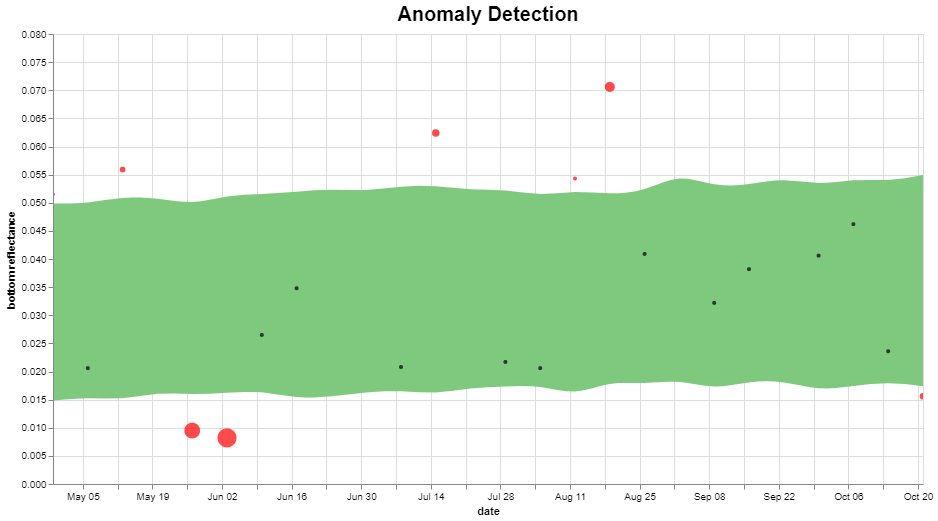

In [10]:
def plot_anomalies(forecasted):
    interval = alt.Chart(forecasted).mark_area(interpolate="basis", color = '#7FC97F').encode(
    x=alt.X('ds:T',  title ='date'),
    y='yhat_upper',
    y2='yhat_lower',
    tooltip=['ds', 'fact', 'yhat_lower', 'yhat_upper','Id']
    ).interactive().properties(
        title='Anomaly Detection'
    )

    fact = alt.Chart(forecasted[forecasted.anomaly==0]).mark_circle(size=15, opacity=0.7, color = 'Black').encode(
        x='ds:T',
        y=alt.Y('fact', title='bottom reflectance'),    
        tooltip=['ds', 'fact', 'yhat_lower', 'yhat_upper','Id']
    ).interactive()

    anomalies = alt.Chart(forecasted[forecasted.anomaly!=0]).mark_circle(size=30, color = 'Red').encode(
        x='ds:T',
        y=alt.Y('fact', title='bottom reflectance'),    
        tooltip=['ds', 'fact', 'yhat_lower', 'yhat_upper','Id'],
        size = alt.Size( 'importance', legend=None)
    ).interactive()

    return alt.layer(interval, fact, anomalies)\
              .properties(width=870, height=450)\
              .configure_title(fontSize=20)
            
plot_anomalies(pred2)

In [20]:
print (pred.Id)

0      1
1      2
2      3
3      4
4      5
5      6
6      7
7      8
8      9
9     10
10    11
11    12
12    13
13    14
14    15
15    16
16    17
17    18
18    19
19    20
20    21
21    22
22    23
23    24
24    25
Name: Id, dtype: int64


In [21]:
print (pred2.Id)

0      1
1      2
2      3
3      4
4      5
5      6
6      7
7      8
8      9
9     10
10    11
11    12
12    13
13    14
14    15
15    16
16    17
17    18
18    19
19    20
20    21
21    22
22    23
23    24
24    25
Name: Id, dtype: int64


In [22]:
print (pred.Id)

0      1
1      2
2      3
3      4
4      5
5      6
6      7
7      8
8      9
9     10
10    11
11    12
12    13
13    14
14    15
15    16
16    17
17    18
18    19
19    20
20    21
21    22
22    23
23    24
24    25
Name: Id, dtype: int64


In [23]:
upper = pred[pred['fact']>pred['yhat_upper']] 
lower = pred[pred['fact']<pred['yhat_lower']] 
#abnorm=pred[pred['anomaly']==0]

In [24]:
print (upper)

Empty DataFrame
Columns: [ds, trend, yhat_lower, yhat_upper, trend_lower, trend_upper, additive_terms, additive_terms_lower, additive_terms_upper, multiplicative_terms, multiplicative_terms_lower, multiplicative_terms_upper, yhat, fact, Id]
Index: []


In [25]:
from IPython.core.display import HTML
display(HTML(upper.to_html()))

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,fact,Id
